In [ ]:
!pip install kneed

 cluster count is 4


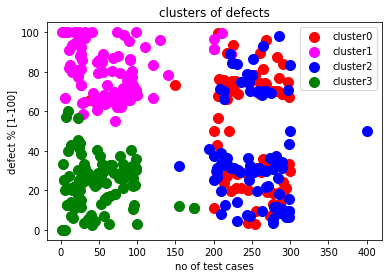

{'file_name': 'cluster_output.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'findhotspot-donotdelete-pr-czadukqqrthr5z',
 'asset_id': '3212dcdf-7e2e-4b80-a0bb-e08f44b3645d'}

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from project_lib import Project
import types
from botocore.client import Config
import ibm_boto3
import ibmos2spark
import types
import pandas as pd




project = Project(sc,"860076b9-9edd-4cb8-a2ba-8094fe03b063","p-506ebf3b50ffd112307a22d4ca48979fc8c2a8d0")


def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_29882ce9c0f74130ab5806368b60732b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='xJSKrPYAlk7lfHfdGXIj7eLJ8b6NNCxQcV4GswzrU3Nh',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_29882ce9c0f74130ab5806368b60732b.get_object(Bucket='findhotspot-donotdelete-pr-czadukqqrthr5z',Key='clustering_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )




dataset_csv = pd.read_csv(body)
cluster_df=dataset_csv[['Module_id','No_of_requirements','No_of_lines_of_code','Hours_spent','No_of_test_cases','No_of_defects']]
def calculate_percentage(row):
     d=row['No_of_defects']/row['No_of_test_cases']
     return d*100

cluster_df['defect_percent']=cluster_df.apply(lambda row : calculate_percentage(row),axis=1)
cluster_df.drop(['No_of_defects'],axis=1,inplace=True)
X=cluster_df.iloc[:,1:].values


scaler = StandardScaler()
X=scaler.fit_transform(X)


def calculate_nclusters():
    cluster_errors=[]
    cluster_range = range(1, 10)
    for i in cluster_range:
        kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
        kmeans.fit(X)
        cluster_errors.append(kmeans.inertia_)

    clusters_df = pd.DataFrame({"cluster_errors": cluster_errors, "num_clusters": cluster_range})
    elbow = KneeLocator(clusters_df.num_clusters.values, clusters_df.cluster_errors.values, S=1.0, curve='convex', direction='decreasing')
    return elbow.knee


cluster_count=calculate_nclusters()
print(" cluster count is {}".format(cluster_count))
kmeans=KMeans(n_clusters=cluster_count,init='k-means++',random_state=42)
#kmeans=AgglomerativeClustering(n_clusters=cluster_count,affinity='euclidean',linkage='ward')
y_means=kmeans.fit_predict(X)
X=scaler.inverse_transform(X)

colors=['red','magenta','blue','green','violet','black','yellow','orange','cyan']

for i in range(cluster_count):
    plt.scatter(X[y_means==i,3],X[y_means==i,4],s=100,c=colors[i],label='cluster{}'.format(i))


#plt.scatter(kmeans.cluster_centers_[:,3],kmeans.cluster_centers_[:,4],s=300,c='yellow',label='centroids')
plt.title('clusters of defects')
plt.xlabel('no of test cases')
plt.ylabel('defect % [1-100]')
plt.legend()
plt.show()

cluster_df['cluster']=y_means
#cluster_df.to_csv('cluster_output.csv', index = False)
project.save_data(file_name = "cluster_output.csv",data = cluster_df.to_csv(index=False),overwrite=True)